In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
def get_metrics(data):
    """
    Get the metrics beased on a dataset resulting from the
    simulations.

    Returns -> list(metrics)
    """

    Y_data = data[:, -1]
    U_data = data[:, :-1]

    IAE = np.sum(np.abs(ysp - Y_data) * dt)
    ITAE = np.sum(t_sim * np.abs(ysp - Y_data) * dt)
    EC = np.sum(np.abs(np.diff(U_data[:, 0])) * dt)

    return [IAE, ITAE, EC]

In [3]:
# SERVO
## loading data

ysp = np.loadtxt("results/ysp.csv", delimiter=",")

t_sim = np.loadtxt("results/PID/PID_servo.csv", delimiter=",")[:, 0]
dt = t_sim[1] - t_sim[0]

PID_servo = np.loadtxt("results/PID/PID_servo.csv", delimiter=",")[:, 1:]
LIN_servo = np.loadtxt("results/LIN/LIN_servo.csv", delimiter=",")[:, 1:]
GRU_servo = np.loadtxt("results/GRU/GRU_servo.csv", delimiter=",")[:, 1:]

PID_reg = np.loadtxt("results/PID/PID_reg.csv", delimiter=",")[:, 1:]
LIN_reg = np.loadtxt("results/LIN/LIN_reg.csv", delimiter=",")[:, 1:]
GRU_reg = np.loadtxt("results/GRU/GRU_reg.csv", delimiter=",")[:, 1:]

servo_df = {
    "PID":get_metrics(PID_servo),
    "LIN":get_metrics(LIN_servo),
    "GRU":get_metrics(GRU_servo),
}

reg_df = {
    "PID":get_metrics(PID_reg),
    "LIN":get_metrics(LIN_reg),
    "GRU":get_metrics(GRU_reg),
}
index = ["IAE", "ITAE", "EC"]
servo_df = pd.DataFrame(servo_df, index=index).T
reg_df = pd.DataFrame(reg_df, index=index).T

servo_df_rel = servo_df.apply(lambda row: (row - servo_df.loc["PID"]) / servo_df.loc["PID"] * 100, axis=1)
reg_df_rel = reg_df.apply(lambda row: (row - reg_df.loc["PID"]) / reg_df.loc["PID"] * 100, axis=1)

servo_df_rel.columns =  [string + " (%)" for string in index]
reg_df_rel.columns =  [string + " (%)" for string in index]

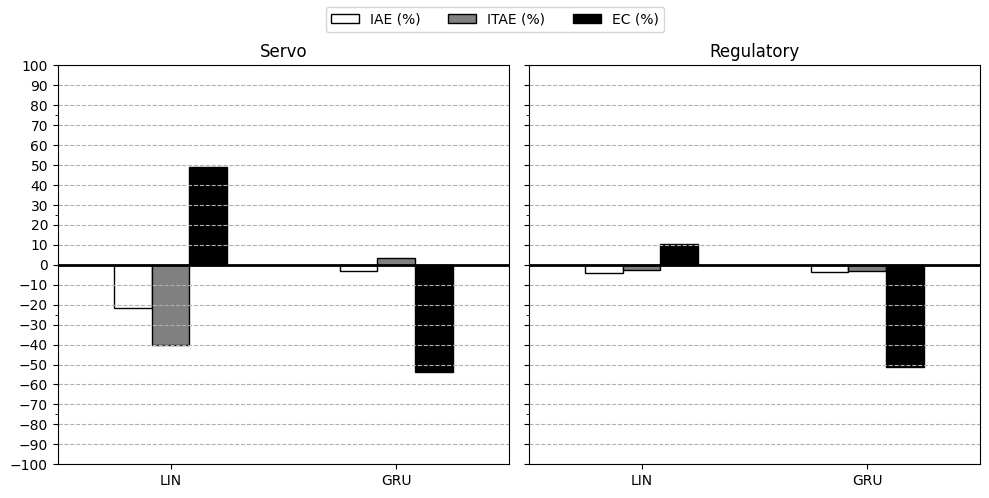

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)
colors = ["white", "grey", "black"]

ax[0].set_title("Servo")
ax[0].axhline(0, c='k', lw=2)
servo_df_rel.loc[["LIN", "GRU"]].plot(kind="bar", ax=ax[0], edgecolor='black', color=colors)
ax[0].grid(axis='y', ls='--')
ax[0].legend_.remove()
ax[0].set_xticklabels(["LIN", "GRU"], rotation=0)

ax[1].set_title("Regulatory")
ax[1].axhline(0, c='k', lw=2)

reg_df_rel.loc[["LIN", "GRU"]].plot(kind="bar", ax=ax[1], edgecolor='black', color=colors)
ax[1].grid(axis='y', ls='--')
ax[1].legend_.remove()
ax[1].set_xticklabels(["LIN", "GRU"], rotation=0)
ax[1].set_yticks(np.arange(-100, 100+10, 10))

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3)
plt.tight_layout(rect=[0, 0, 1, 0.95])